In [1]:
# import fastdtw

# Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def get(train_size,val_size,test_size):
    '''
    remember to adjust your file path
    '''
    import numpy as np
    import json
    with open('/home/yz3698/label.json') as f:
        label=json.load(f)
    with open('/home/yz3698/non_sequential_features.json') as f:
        non_sequential_features=json.load(f)
    with open('/home/yz3698/padded_sequential_features_3.json') as f:
        sequential_features=json.load(f)

    feature1=np.array([sequential_features[key] for key in sequential_features.keys()])
    feature2=np.array([non_sequential_features[key] for key in non_sequential_features.keys()])
    label=np.array([label[key] for key in label.keys()])
    feature1_benign=feature1[label==1]
    feature2_benign=feature2[label==1]
    label_benign=label[label==1]  
    
    idx=np.arange(len(label))
    np.random.shuffle(idx)
    
    
    idx_train=idx[:train_size]
    idx_val=idx[train_size:train_size+val_size]
    idx_test=idx[train_size+val_size:train_size+val_size+test_size]
    
    
    train_seq,val_seq,test_seq=feature1[idx_train],feature1[idx_val],feature1[idx_test]
    train_non,val_non,test_non=feature2[idx_train],feature2[idx_val],feature2[idx_test]
    train_Y,val_Y,test_Y=label[idx_train],label[idx_val],label[idx_test]
    
    return (train_seq,train_non,train_Y),(val_seq,val_non,val_Y),(test_seq,test_non,test_Y)

In [4]:
train,val,test=get(train_size=60000,val_size=5000,test_size=20000)

In [5]:
from sklearn.metrics import roc_curve

In [6]:
def get_KS(y_prob,y_true):
    ''' 
    y_prob: the predict_proba from the model
    y_true: the true label of Y
    this one calculates the KS value for a model
    return the best threshold, maximum ks
    '''
    from sklearn.metrics import roc_curve
    fpr,tpr,threshold=roc_curve(y_true,y_prob)
    ks=(tpr-fpr)
    max_=np.argmax(ks)
    
    return threshold[max_],np.max(ks)

# KNN

In [7]:
import sklearn

# CNN+LSTM

In [8]:
train_seq,train_non,train_Y=train

In [9]:
import json
import numpy as np

In [10]:
import sklearn.preprocessing as pre

In [11]:
values=np.concatenate([np.unique(train_seq[:,:,0]),np.unique(train_seq[:,:,0])+100\
       ,np.unique(train_seq[:,:,0])+1000,np.unique(train_seq[:,:,0])+1100,np.unique(train_seq[:,:,0])-100\
                      ,np.unique(train_seq[:,:,0])-1000\
                      ,np.unique(train_seq[:,:,0])-1100],axis=0)

In [12]:
# generating a label_encoder instance
fitter=pre.LabelEncoder()
fitter.fit(values[:,np.newaxis])

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [13]:
fitter.transform(values)

array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [15]:
import sklearn.preprocessing as pre

In [16]:
def Labelhotter(data,fitter):
    '''
    combining pid, sid, page_type into one kind of label
    combining together and then every value in the output represent a status of (page_type, pid, sid)
    '''
    trans=data[:,:,0]+data[:,:,-1]*1000+data[:,:,-2]*100
    store=[]
    for i in range(60):
        store.append(np.array(fitter.transform(trans[:,i]))[:,np.newaxis])
    store=np.concatenate(store,axis=1)
    
    
    return np.concatenate([store[:,:,np.newaxis],data[:,:,14:-2]],axis=-1)

In [17]:
Labelhotter(train_seq[:100],fitter=fitter).shape

(100, 60, 3)

In [18]:
def non_onehot(data,size):
    return data
t=pre.OneHotEncoder()
train_Y=(t.fit_transform(train_Y[:,np.newaxis])).todense()

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [19]:
train_seq=non_onehot(train_seq,14)

In [20]:
train_seq.shape,train_non.shape,train_Y.shape

((60000, 60, 18), (60000, 14), (60000, 2))

In [21]:
val_seq,val_non,val_Y=val
val_seq=non_onehot(val_seq,14)
val_Y=(t.fit_transform(val_Y[:,np.newaxis])).todense()
val_seq.shape,val_non.shape,val_Y.shape

/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


((5000, 60, 18), (5000, 14), (5000, 2))

In [22]:
import tensorflow.keras as keras
from pyts.image import GramianAngularField as GAF
from pyts.image import MarkovTransitionField as MTF

In [23]:
from tensorflow.keras import metrics

In [24]:
from sklearn.metrics import auc, roc_curve

In [25]:
class CNN_LSTM:
    def __init__(self,data,data_non_seq,features,bins_list,size,strategy,label,fitter,name=None):
        '''
        data: training data, sequential data
        data_non_seq: training data, non_sequential data
        bins_list: the bins you want for different features when generating MTF
        features: the number of features you feed into the model
        size: fig_size for MTF and GAF ( not apply in this project since we only use LSTM)
        strategy: the strategy for generating MTF, usually use normal
        label: the training label, Y
        
        Here, CNN_ stands for embedding
        '''
        
        self.size=size
        self.strategy=strategy
        self.true_features=features
        self.bins_list=bins_list
        self.label=label
        self.fitter=fitter
        
        tp_shape=data_non_seq.shape
        self.non_seq_shape=(tp_shape[1],)
        
        testing=self.transform_used(100,data,data_non_seq,label=self.label)
        tp_shape=(next(testing)[0]).shape
        self.img_shape=(tp_shape[1],)
        
        
        self.CNN=self.CNN_embedding()
        self.LSTM=self.LSTM_()
        self.non_sequential_NN=self.non_sequential_NN_()
        if name:
            self.complete_model=keras.models.load_model(name)
        else:    
            self.complete_model=self.whole_model()
            
#         self.complete_model=self.whole_model()
        
        optimizer=keras.optimizers.Adam(lr=0.0002,beta_1=0.5)
#         optimizer=keras.optimizers.Adagrad(learning_rate=0.0001)
        self.CNN.trainable=True
        self.LSTM.trainable=True
        self.non_sequential_NN.trainable=True
        self.complete_model.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy'])

#         metrics : for storing the models. only when the model has higher KS and higher AUC in validation 
#         dataset, will we store the model for later use        
        self.metrics=[0,0,0,0,0]
    
    
    
    def transform_used(self,batch_size,data_used,data_non,label,\
                       random_or_not=True,train=True):
        '''
        data_used: sequentila data 
        data_non: non_sequential data
        label: label for training
        random_or_not:False, not random, True, will shuffle it. 
        this will be important when you are not training data. Since we will sometimes use this 
        function generating data for prediction. And the label will then can be randomly assigned
        
        output: data for embedding layer; non_sequential data, time-series data for LSTM, label 
        '''        
        X_train=data_used

#         for epoch in range(epochs):
        whole=len(X_train)//batch_size+(len(X_train)%batch_size!=0)
        total_loss=0
        
        idx=np.arange(len(data_used))
        if random_or_not:
            np.random.shuffle(idx)
        else:
            pass
        for step in range(whole):
            imgs=X_train[idx[step*batch_size:(step+1)*batch_size]]
#                 get the whole transformed_data
         
            non_seq_data=data_non[idx[step*batch_size:(step+1)*batch_size]]
        
            using_data=X_train[idx[step*batch_size:(step+1)*batch_size]]
            
            data_seq_lstm=Labelhotter(using_data,self.fitter)
            seq_data=data_seq_lstm[:,:,0]
            lstm_data=using_data[:,:,1:]
            
            return_label=label[idx[step*batch_size:(step+1)*batch_size]]
            
            yield(seq_data,non_seq_data,lstm_data,return_label)

    def CNN_embedding(self):
        '''
        keras model. CNN
        '''
        dropout=0.5
        
        model=keras.Sequential()
        
        model.add(keras.layers.Embedding(input_dim=84,output_dim=256,input_length=60,input_shape=self.img_shape\
                                        ,trainable=True))
        model.add(keras.layers.Reshape((256,60,1)))
        
        model.add(keras.layers.Conv2D(filters=32,kernel_size=4,strides=(2,1),padding='same',activation='relu'))
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,1),padding='same'))        
        model.add(keras.layers.Conv2D(filters=1,kernel_size=4,strides=(2,1),padding='same',activation='relu'))
        model.add(keras.layers.AveragePooling2D(pool_size=4,strides=(2,1),padding='same'))
        model.add(keras.layers.Reshape((16,60)))
        
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, activation="tanh",\
                                                                return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
                  
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(16, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64,activation="relu"))

        img=keras.Input(shape=self.img_shape)
        val=model(img)
        
        model.summary()
        return keras.Model(img,val)
            
        
    def LSTM_(self):
        '''
        LSTM keras model, try to handel original data     
        adding 1-D convolution first
        
        
        '''
#         from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
        
        timesteps=60
        n_features=17
        model=keras.Sequential()
        model.add(keras.layers.Conv1D(filters=64,kernel_size=4,padding='same',activation='relu',strides=1\
                                     ,input_shape=(timesteps,n_features)))
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(128, activation="tanh",\
                                                                return_sequences=True)))
#         model.add(Bidirectional(keras.layers.LSTM(128, activation="tanh", return_sequences=True)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
                  
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, activation="tanh", return_sequences=False)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation("tanh"))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(units=64,activation="relu"))
        
        inp=keras.Input(shape=(timesteps,n_features))
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
    
    
        
        
    def non_sequential_NN_(self):
        '''
        Neural network for NN
        '''
        dropout=0.5
        n_features=self.non_seq_shape
        model=keras.Sequential()
        model.add(keras.layers.Dense(128,activation="relu",input_shape=n_features))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
        model.add(keras.layers.Dense(64,activation="relu"))
        model.add(keras.layers.BatchNormalization(momentum=0.8))
        model.add(keras.layers.ReLU())
        model.add(keras.layers.Dropout(dropout))
        
        model.add(keras.layers.Dense(64,activation="relu"))
#         
        inp=keras.Input(shape=n_features)
        out=model(inp)
        model.summary()
        return keras.Model(inp,out)
        
        
    def whole_model(self):
        '''
        putting all models together
        '''
        dropout=0.5
        seq_inp=keras.Input(shape=self.img_shape)
#         non_inp=keras.Input(shape=self.non_seq_shape)
        LSTM_inp=keras.Input(shape=(60,17))
        
        seq=self.CNN(seq_inp)
#         non_seq=self.non_sequential_NN(non_inp)
        rnn=self.LSTM(LSTM_inp)
        
#         model=keras.Sequential()
        concat_=keras.layers.concatenate([seq,rnn])
#         concat_=non_seq
        flat=keras.layers.Flatten()(concat_)
        act1=keras.layers.Dense(128,activation="relu")(flat)
        norm1=keras.layers.BatchNormalization()(act1)
        drop1=keras.layers.Dropout(dropout)(norm1)
        
#         act2=keras.layers.Dense(64,activation="relu")(drop1)
#         drop2=keras.layers.Dropout(dropout)(act2)
        
        act3=keras.layers.Dense(16,activation="relu")(drop1)
        norm3=keras.layers.BatchNormalization()(act3)
        drop4=keras.layers.Dropout(dropout)(norm3)
        
        out=keras.layers.Dense(2,activation="softmax")(drop4)
        
        model=keras.Model(inputs=[seq_inp,LSTM_inp],outputs=out)
        model.summary()
        return model
    
    def training(self,epochs,batch_size,show_epoch,data,data_non,label,\
                 val_seq,val_non,val_Y,path=None):
        
        data_used=data
        for epoch in range(epochs):
            gener=self.transform_used(batch_size,data,data_non,label)
            whole=len(data_used)//batch_size+(len(data_used)%batch_size!=0)
            total_loss=0
            mean_accuracy=0

            for step in range(whole):
                imgs,non_seq_data,lstm_data,label_batch=next(gener)
                loss=self.complete_model.fit([imgs,lstm_data],label_batch,batch_size=batch_size,epochs=1,verbose=0)
#                 self.complete_model.train_on_batch()
#                 total_loss+=(loss.loss[0]/whole)
#                 mean_accuracy+=(loss.loss[1]/whole)

            if epoch%show_epoch==0:
                
                predict_prob,predict=self.model_predict(model=self.complete_model,data_seq=val_seq,data_non=val_non,\
                                               batch_size=100)
                val_acc=np.mean(predict==val_Y[:,1])
                _,val_KS=get_KS(predict_prob[:,1],val_Y[:,1])
                fpr,tpr,threshold=roc_curve(val_Y[:,1],predict_prob[:,1])
                val_auc=auc(fpr,tpr)
                self.saver(name="embedding_LSTM_show1.ipynb_epoch"+str(epoch)+".h5",model=self.complete_model,\
                          metrics=[val_KS,val_auc])
                
#                 print("training on epoch: {}, loss is {}".format(epoch,total_loss))
#                 print("training on epoch: {}, accuracy is {}".format(epoch,mean_accuracy))
                print("training on epoch: {}, validation accuracy is {}".format(epoch,val_acc))
                print("training on epoch: {}, validation KS is {}".format(epoch,val_KS))
                print("training on epoch: {}, validation AUC is {}".format(epoch,val_auc))
                print("balance_status of validation set have {} of ones in val".format(np.sum(val_Y[:,1])/len(val_Y)))
                
                fpr, tpr, threshold = roc_curve(val_Y[:,1],predict_prob[:,1])                
                plt.title('ROC')
                plt.plot(fpr, tpr, 'b')
                plt.legend(loc = 'lower right')
                plt.plot([0, 1], [0, 1],'r--')
                plt.xlim([0, 1])
                plt.ylim([0, 1])
                plt.ylabel('True Positive Rate')
                plt.xlabel('False Positive Rate')
                plt.show()
                
                
#                 a=self.sample_images(X=X,epoch=epoch)
                print("------------generate form-------------------------------------------")
                print("--------------------------------------------------------------------")
                
        
    def saver(self,name,model,metrics=None):
        if metrics==None:
            model.save(name)
        else:
            if (metrics[0]>self.metrics[0]) and (metrics[1]>self.metrics[1]):
                model.save(name)
                self.metrics=metrics
                print("-----------------------saving models------------------------------")
            else:
                pass


    def model_predict(self,model,data_seq,data_non,batch_size):
        '''
        return prediction for using batch_size
        '''
        fake_label=np.arange(len(data_non))
        k=self.transform_used(batch_size,data_used=data_seq,data_non=data_non,label=fake_label,\
                             random_or_not=False,train=False)
        store=[]
        for i in range(len(data_seq)//batch_size+(len(data_seq)%batch_size!=0)):

            test_dataset=next(k)
            
            d0=test_dataset[0]
#             d1=test_dataset[1]
            d2=test_dataset[2]
#                     pay attention to the d1 d2 here. you need to adjust it
            test_predict_prob=model.predict([d0,d2])
            store.append(test_predict_prob)
        store=np.concatenate(store)
        prob=store
        prediction=np.argmax(prob,axis=-1)
        return prob,prediction        
        
        
        
        

In [26]:
bins_list=[2,2,2,2,2,2,2,2,2,2,2,2,2,10,10,10,10,10]
data=train_seq
data_non_seq=train_non
features=18
size=60
strategy="uniform"
label=train_Y
test_model=CNN_LSTM(data=data,data_non_seq=data_non_seq,features=features,bins_list=bins_list,\
                    size=size,strategy=strategy,label=train_Y,fitter=fitter)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 256)           21504     
_________________________________________________________________
reshape (Reshape)            (None, 256, 60, 1)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 60, 32)       544       
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 60, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 60, 1)         513       
_________________________________________________________________
average_pooling2d_1 (Average (None, 16, 60, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 60)            0

No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 0, validation accuracy is 0.9236
training on epoch: 0, validation KS is 0.025617943898108675
training on epoch: 0, validation AUC is 0.4991119997097631
balance_status of validation set have 0.0764 of ones in val


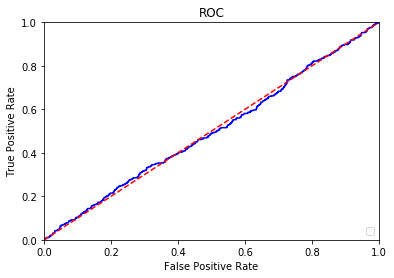

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 2, validation accuracy is 0.9236
training on epoch: 2, validation KS is 0.03468898165385165
training on epoch: 2, validation AUC is 0.5098448139422564
balance_status of validation set have 0.0764 of ones in val


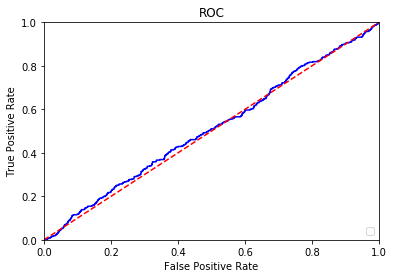

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 4, validation accuracy is 0.9236
training on epoch: 4, validation KS is 0.047290479548500186
training on epoch: 4, validation AUC is 0.5132721039229602
balance_status of validation set have 0.0764 of ones in val


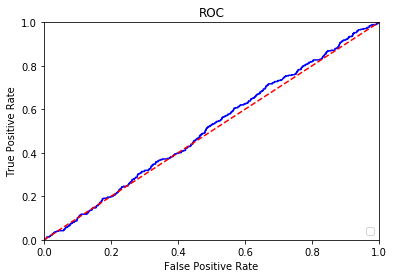

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 6, validation accuracy is 0.9236
training on epoch: 6, validation KS is 0.04647532192490578
training on epoch: 6, validation AUC is 0.5231565986952943
balance_status of validation set have 0.0764 of ones in val


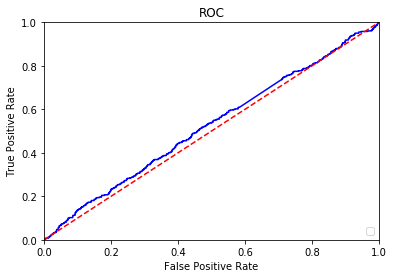

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 8, validation accuracy is 0.9236
training on epoch: 8, validation KS is 0.017139851117525584
training on epoch: 8, validation AUC is 0.49155620279398393
balance_status of validation set have 0.0764 of ones in val


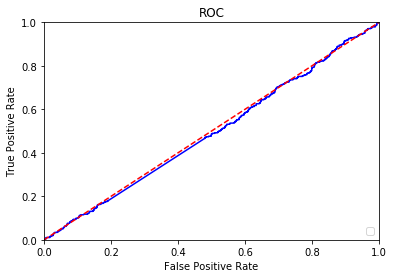

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 10, validation accuracy is 0.9236
training on epoch: 10, validation KS is 0.05744423709636093
training on epoch: 10, validation AUC is 0.5247577201889262
balance_status of validation set have 0.0764 of ones in val


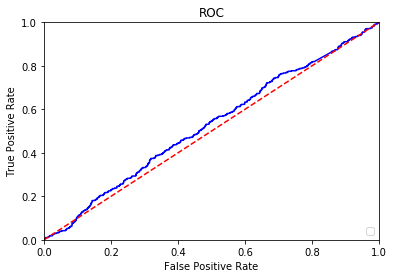

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 12, validation accuracy is 0.9236
training on epoch: 12, validation KS is 0.06035000759604463
training on epoch: 12, validation AUC is 0.5295129008047272
balance_status of validation set have 0.0764 of ones in val


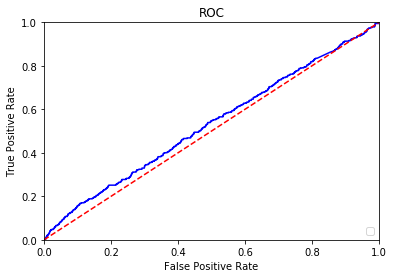

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 14, validation accuracy is 0.9236
training on epoch: 14, validation KS is 0.026189347851226397
training on epoch: 14, validation AUC is 0.4986695584543977
balance_status of validation set have 0.0764 of ones in val


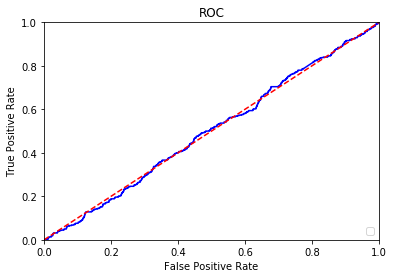

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 16, validation accuracy is 0.9236
training on epoch: 16, validation KS is 0.03575809658994289
training on epoch: 16, validation AUC is 0.5029035030236794
balance_status of validation set have 0.0764 of ones in val


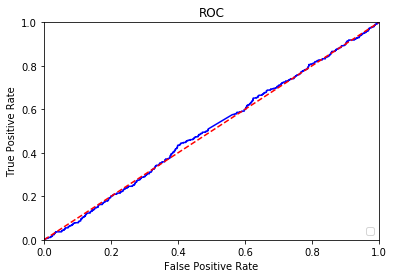

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 18, validation accuracy is 0.9236
training on epoch: 18, validation KS is 0.006821701559343252
training on epoch: 18, validation AUC is 0.4814441101177046
balance_status of validation set have 0.0764 of ones in val


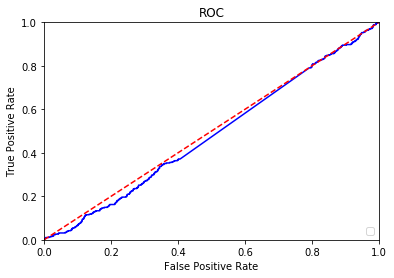

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 20, validation accuracy is 0.9236
training on epoch: 20, validation KS is 0.013325956478065573
training on epoch: 20, validation AUC is 0.4934438765676763
balance_status of validation set have 0.0764 of ones in val


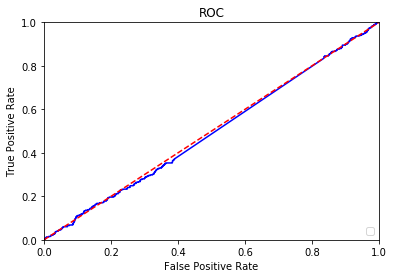

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 22, validation accuracy is 0.9236
training on epoch: 22, validation KS is 0.03551434291946609
training on epoch: 22, validation AUC is 0.5034190703801877
balance_status of validation set have 0.0764 of ones in val


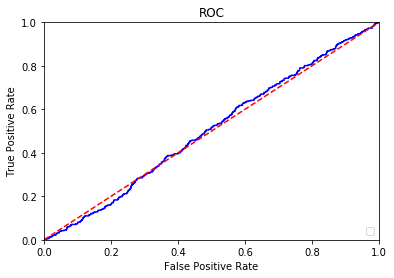

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 24, validation accuracy is 0.9236
training on epoch: 24, validation KS is 0.031300238765223365
training on epoch: 24, validation AUC is 0.5007788780075235
balance_status of validation set have 0.0764 of ones in val


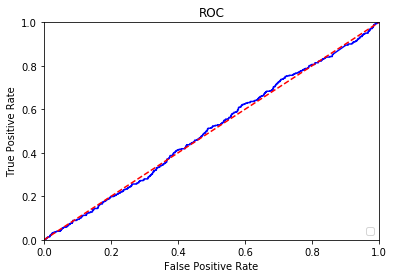

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 26, validation accuracy is 0.9236
training on epoch: 26, validation KS is 0.01988689829689877
training on epoch: 26, validation AUC is 0.498273033588122
balance_status of validation set have 0.0764 of ones in val


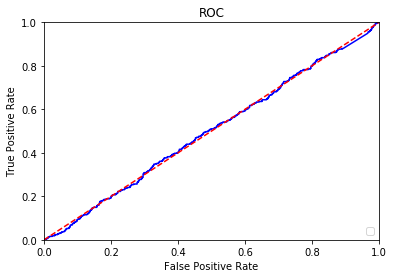

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 28, validation accuracy is 0.9236
training on epoch: 28, validation KS is 0.010811325589146936
training on epoch: 28, validation AUC is 0.48963876839773357
balance_status of validation set have 0.0764 of ones in val


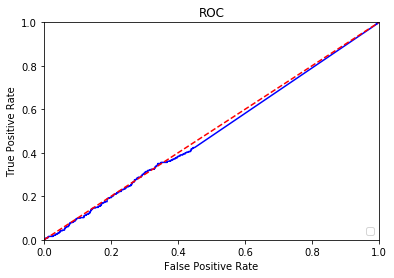

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 30, validation accuracy is 0.9236
training on epoch: 30, validation KS is 0.06626698622961824
training on epoch: 30, validation AUC is 0.5269407327121961
balance_status of validation set have 0.0764 of ones in val


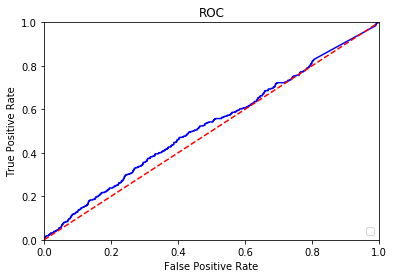

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 32, validation accuracy is 0.9236
training on epoch: 32, validation KS is 0.04118303293055403
training on epoch: 32, validation AUC is 0.5160545804149028
balance_status of validation set have 0.0764 of ones in val


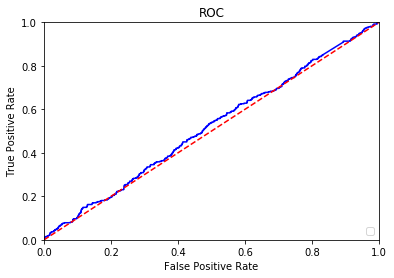

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 34, validation accuracy is 0.9236
training on epoch: 34, validation KS is 0.03381600339214408
training on epoch: 34, validation AUC is 0.5054544135286689
balance_status of validation set have 0.0764 of ones in val


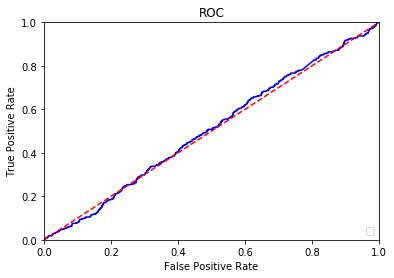

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 36, validation accuracy is 0.9236
training on epoch: 36, validation KS is 0.05624587602801692
training on epoch: 36, validation AUC is 0.5227416505864826
balance_status of validation set have 0.0764 of ones in val


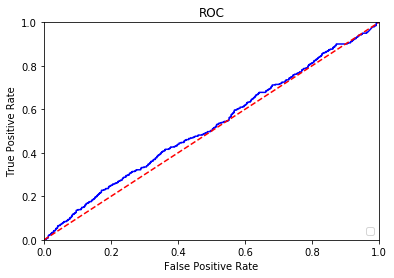

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


-----------------------saving models------------------------------
training on epoch: 38, validation accuracy is 0.9236
training on epoch: 38, validation KS is 0.07715200478890932
training on epoch: 38, validation AUC is 0.5343122972026147
balance_status of validation set have 0.0764 of ones in val


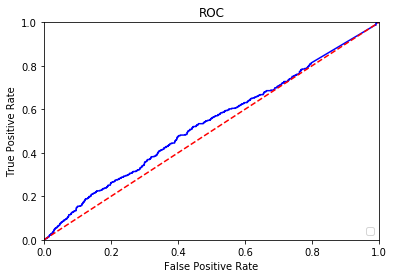

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 40, validation accuracy is 0.9236
training on epoch: 40, validation KS is 0.041135415934460906
training on epoch: 40, validation AUC is 0.5139917441198678
balance_status of validation set have 0.0764 of ones in val


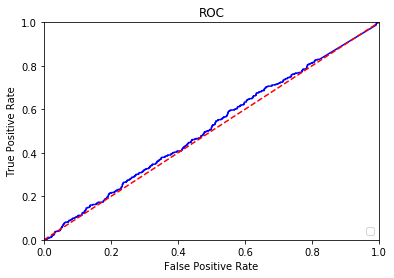

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 42, validation accuracy is 0.9236
training on epoch: 42, validation KS is 0.013223920057865986
training on epoch: 42, validation AUC is 0.48661622288382134
balance_status of validation set have 0.0764 of ones in val


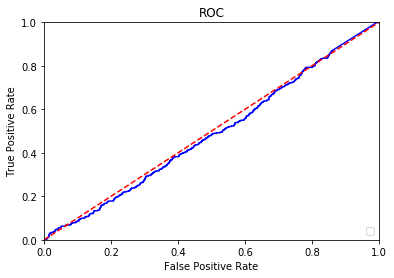

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 44, validation accuracy is 0.9236
training on epoch: 44, validation KS is 0.03700747586838671
training on epoch: 44, validation AUC is 0.5013239225520896
balance_status of validation set have 0.0764 of ones in val


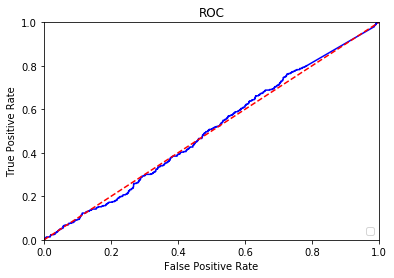

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 46, validation accuracy is 0.9236
training on epoch: 46, validation KS is 0.011127638491765679
training on epoch: 46, validation AUC is 0.4859424990760037
balance_status of validation set have 0.0764 of ones in val


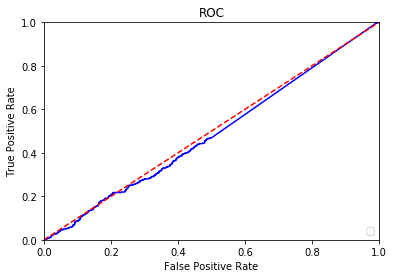

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 48, validation accuracy is 0.9236
training on epoch: 48, validation KS is 0.027001104260814156
training on epoch: 48, validation AUC is 0.5076734222335092
balance_status of validation set have 0.0764 of ones in val


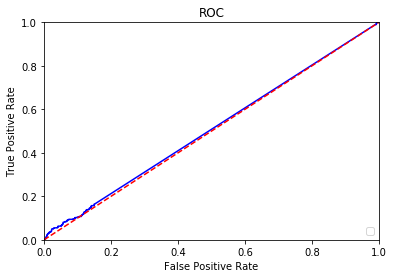

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 50, validation accuracy is 0.9236
training on epoch: 50, validation KS is 0.008560855654745032
training on epoch: 50, validation AUC is 0.4888105727871134
balance_status of validation set have 0.0764 of ones in val


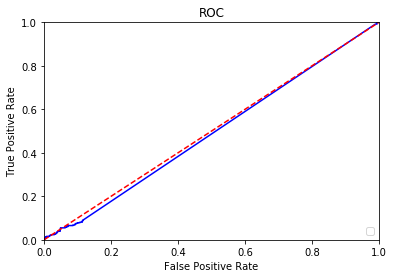

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 52, validation accuracy is 0.9236
training on epoch: 52, validation KS is 0.055021438985621896
training on epoch: 52, validation AUC is 0.5165537085703791
balance_status of validation set have 0.0764 of ones in val


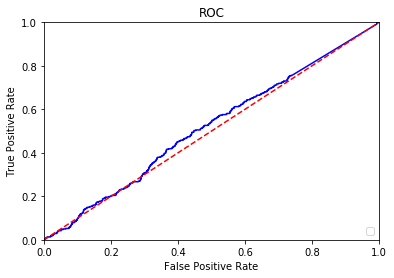

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 54, validation accuracy is 0.9236
training on epoch: 54, validation KS is 0.02077121393862849
training on epoch: 54, validation AUC is 0.5051312981980368
balance_status of validation set have 0.0764 of ones in val


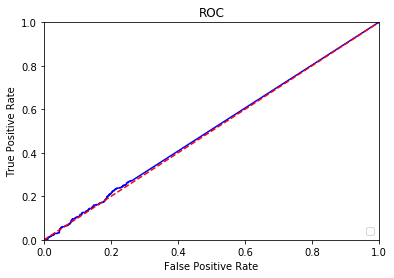

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 56, validation accuracy is 0.9236
training on epoch: 56, validation KS is 0.016289547615862356
training on epoch: 56, validation AUC is 0.5054666012121928
balance_status of validation set have 0.0764 of ones in val


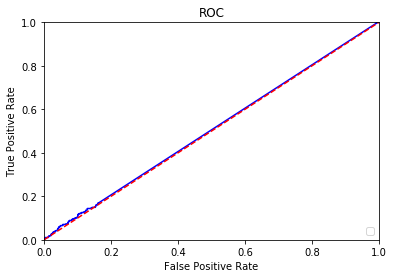

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 58, validation accuracy is 0.9236
training on epoch: 58, validation KS is 0.03399400025849231
training on epoch: 58, validation AUC is 0.49126284808591014
balance_status of validation set have 0.0764 of ones in val


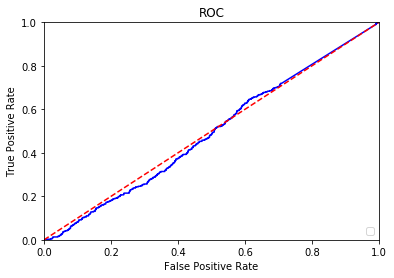

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 60, validation accuracy is 0.9236
training on epoch: 60, validation KS is 0.02180971794865981
training on epoch: 60, validation AUC is 0.5014219908892814
balance_status of validation set have 0.0764 of ones in val


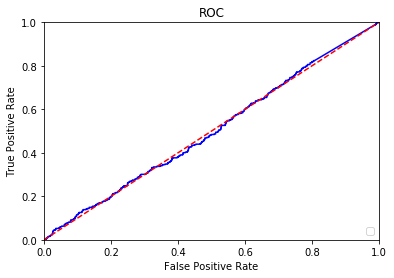

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 62, validation accuracy is 0.9236
training on epoch: 62, validation KS is 0.0038977912516240387
training on epoch: 62, validation AUC is 0.49398041807722576
balance_status of validation set have 0.0764 of ones in val


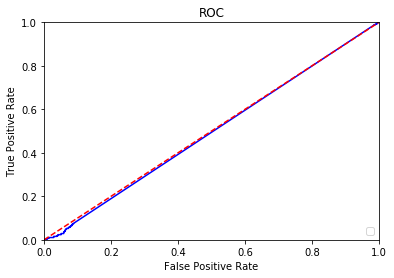

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 64, validation accuracy is 0.9236
training on epoch: 64, validation KS is 0.008931587981470184
training on epoch: 64, validation AUC is 0.49617306737351446
balance_status of validation set have 0.0764 of ones in val


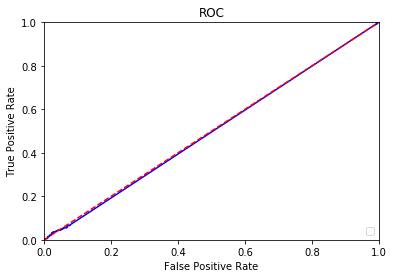

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 66, validation accuracy is 0.9236
training on epoch: 66, validation KS is 0.04014226144451827
training on epoch: 66, validation AUC is 0.5151300170740944
balance_status of validation set have 0.0764 of ones in val


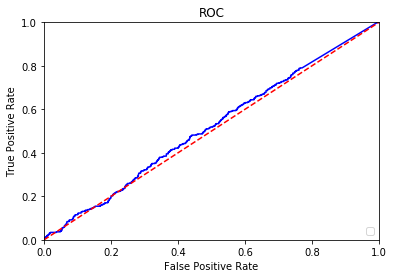

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 68, validation accuracy is 0.9236
training on epoch: 68, validation KS is 0.01786771091494924
training on epoch: 68, validation AUC is 0.5082099637430587
balance_status of validation set have 0.0764 of ones in val


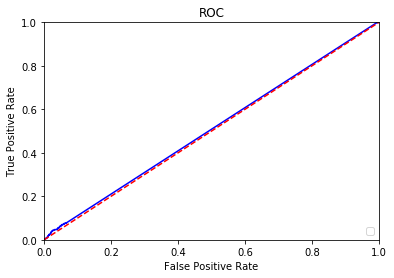

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 70, validation accuracy is 0.9236
training on epoch: 70, validation KS is 0.04040642239903497
training on epoch: 70, validation AUC is 0.5120950004421577
balance_status of validation set have 0.0764 of ones in val


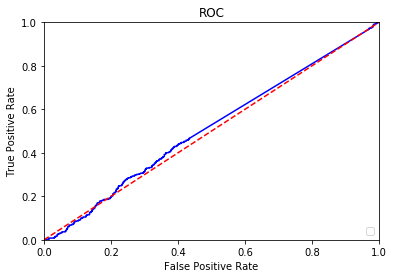

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 72, validation accuracy is 0.9236
training on epoch: 72, validation KS is 0.010014307773587982
training on epoch: 72, validation AUC is 0.49054037354399693
balance_status of validation set have 0.0764 of ones in val


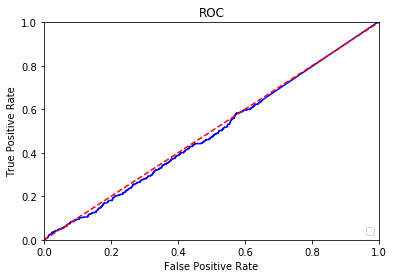

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 74, validation accuracy is 0.9236
training on epoch: 74, validation KS is 0.01231919713209635
training on epoch: 74, validation AUC is 0.5038515914280338
balance_status of validation set have 0.0764 of ones in val


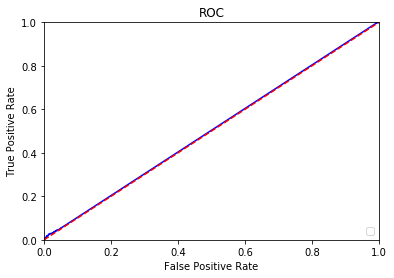

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 76, validation accuracy is 0.9236
training on epoch: 76, validation KS is 0.010548298372632473
training on epoch: 76, validation AUC is 0.5029771959938234
balance_status of validation set have 0.0764 of ones in val


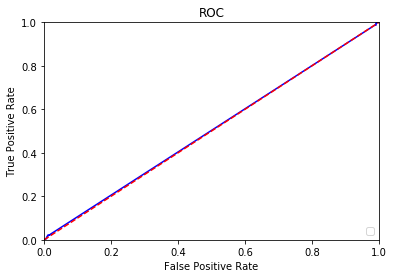

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 78, validation accuracy is 0.9236
training on epoch: 78, validation KS is 0.006477045206669141
training on epoch: 78, validation AUC is 0.49129912770198103
balance_status of validation set have 0.0764 of ones in val


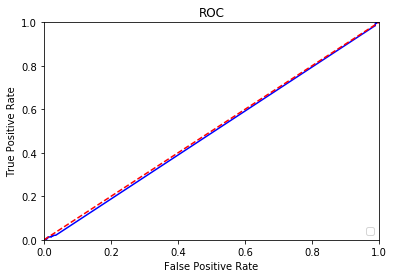

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 80, validation accuracy is 0.9236
training on epoch: 80, validation KS is 0.015605903600525144
training on epoch: 80, validation AUC is 0.5081909736315217
balance_status of validation set have 0.0764 of ones in val


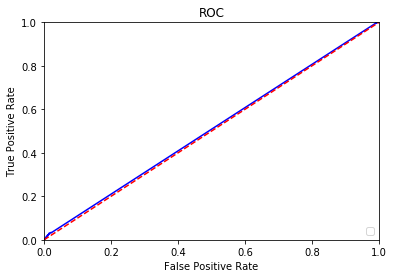

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 82, validation accuracy is 0.9236
training on epoch: 82, validation KS is 0.005630142919012537
training on epoch: 82, validation AUC is 0.5044411351891869
balance_status of validation set have 0.0764 of ones in val


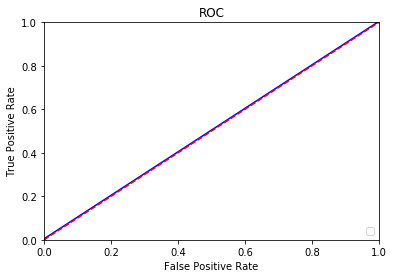

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 84, validation accuracy is 0.9236
training on epoch: 84, validation KS is 0.00626050124824562
training on epoch: 84, validation AUC is 0.5030576913919809
balance_status of validation set have 0.0764 of ones in val


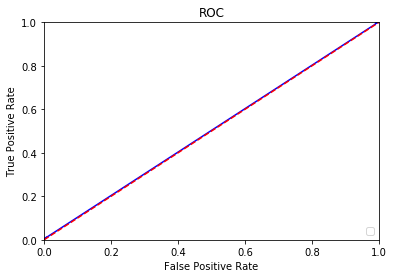

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 86, validation accuracy is 0.9236
training on epoch: 86, validation KS is 0.006847777533394252
training on epoch: 86, validation AUC is 0.49802446153113583
balance_status of validation set have 0.0764 of ones in val


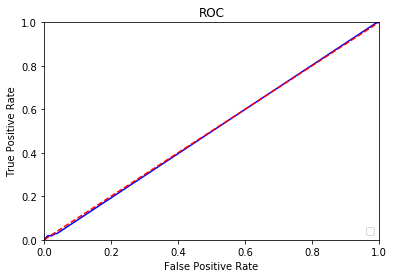

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 88, validation accuracy is 0.9236
training on epoch: 88, validation KS is 0.006496318752706842
training on epoch: 88, validation AUC is 0.5016294649436872
balance_status of validation set have 0.0764 of ones in val


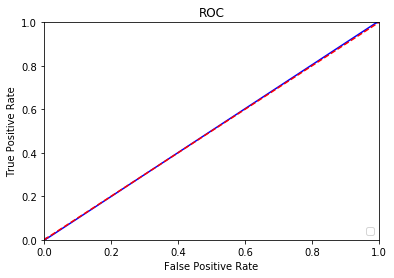

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 90, validation accuracy is 0.9236
training on epoch: 90, validation KS is 0.006496318752706842
training on epoch: 90, validation AUC is 0.5046537110646027
balance_status of validation set have 0.0764 of ones in val


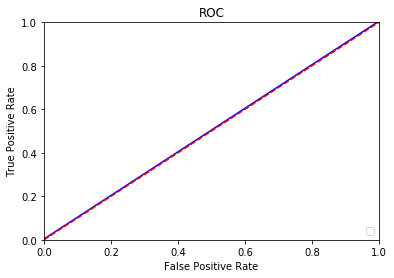

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 92, validation accuracy is 0.9236
training on epoch: 92, validation KS is 0.020298445191703762
training on epoch: 92, validation AUC is 0.5023247297735473
balance_status of validation set have 0.0764 of ones in val


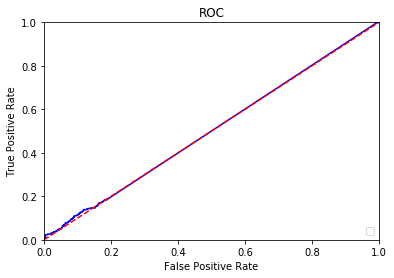

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 94, validation accuracy is 0.9236
training on epoch: 94, validation KS is 0.010134484001823051
training on epoch: 94, validation AUC is 0.5075274534657237
balance_status of validation set have 0.0764 of ones in val


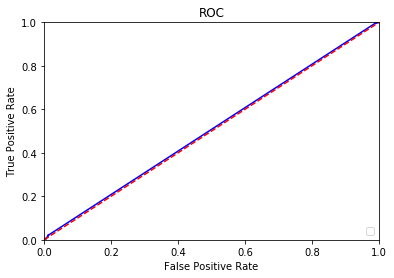

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 96, validation accuracy is 0.9236
training on epoch: 96, validation KS is 0.005413598960589017
training on epoch: 96, validation AUC is 0.5020591516465278
balance_status of validation set have 0.0764 of ones in val


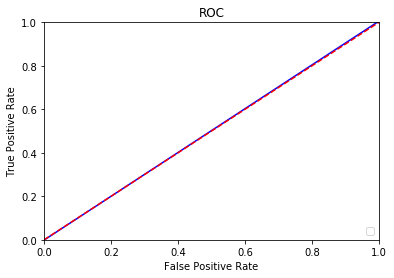

------------generate form-------------------------------------------
--------------------------------------------------------------------


No handles with labels found to put in legend.


training on epoch: 98, validation accuracy is 0.9236
training on epoch: 98, validation KS is 0.002184713130273299
training on epoch: 98, validation AUC is 0.5007678240620019
balance_status of validation set have 0.0764 of ones in val


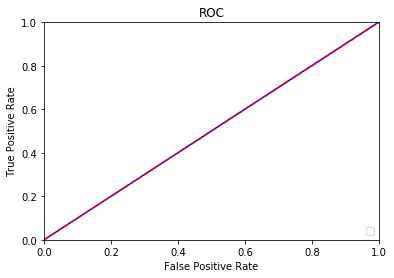

------------generate form-------------------------------------------
--------------------------------------------------------------------


In [27]:
test_model.training(epochs=100,batch_size=1000,show_epoch=2,data=data,data_non=data_non_seq,label=train_Y\
                   ,val_seq=val_seq,val_non=val_non,val_Y=val_Y)

In [28]:

test_seq,test_non,test_Y=test
test_seq=non_onehot(test_seq,14)
test_Y=(t.fit_transform(test_Y[:,np.newaxis])).todense()
test_seq.shape,test_non.shape,test_Y.shape


/usr/local/share/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


((20000, 60, 18), (20000, 14), (20000, 2))

In [29]:
# YY_prob.shape

In [30]:
# YY_prob=test_model.non_sequential_NN.predict(test_non)
# np.sum(YY_prob,axis=-1)

In [31]:
# np.sum(YY_prob)

In [32]:
73338.695

73338.695

In [33]:
# YL_prob=test_model.LSTM.predict(test_seq)
# np.sum(YL_prob,axis=-1)

In [34]:
# np.sum(YL_prob)

In [36]:
k=test_model.transform_used(500,data_used=test_seq,data_non=test_non,label=train_Y,\
                            random_or_not=False,train=False)
store=[]
for i in range(len(test_seq)//500+(len(test_seq)%500!=0)):
    test_dataset=next(k)
    d0=test_dataset[0]
    d1=test_dataset[1]
    d2=test_dataset[2]
    test_predict_prob=test_model.complete_model.predict([d0,d2])
    store.append(test_predict_prob)
store=np.concatenate(store,axis=0)
test_predict_prob=store
test_predict=np.argmax(test_predict_prob,axis=-1)
acc=np.mean(test_predict==test_Y[:,1])
test_ks=get_KS(test_predict_prob[:,1],test_Y[:,1])
acc,test_ks

(0.93145, (0.06310819, 0.0018472332358366872))

No handles with labels found to put in legend.


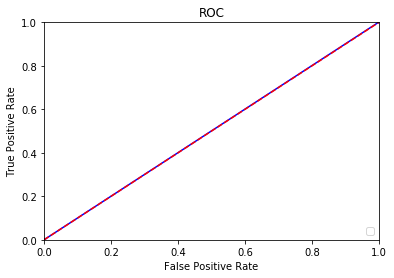

In [37]:
fpr, tpr, threshold = roc_curve(test_Y[:,1],test_predict_prob[:,1])                
plt.title('ROC')
plt.plot(fpr, tpr, 'b')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
